# Preparação do ambiente

## Bibliotecas

In [1]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import string

from os import path as osp
from pprint import pprint
from tabulate import tabulate

## Constantes e funções auxiliares

In [30]:
NULL_STRING = '#NULLO#'
FILE_ANUNCIOS = '../datasets/anuncios.parquet'

FILE_FISCAIS = '../datasets/label_issues/20240423/fiscais_to_label.xlsx'
FILE_SAMPLES = '../datasets/label_issues/20240423/samples.parquet'
FILE_ISSUES_TO_FISCALIZA = '../datasets/label_issues/20240423/issues_to_fiscaliza.txt'
FILE_FULL_ISSUES = '../datasets/label_issues/20240423/full_issues.parquet'

In [12]:
def flatten_matrix(matrix):
    return [item for row in matrix for item in row]

In [13]:
def extract_amazon_images(row):
    imagens = []
    imagens.append(row['Imagem'].split()[0])
    imagens.extend(row['Imagens'].split())

    imagens = [imagem for imagem in imagens if imagem.startswith('http')]
    if len(imagens) >= 3:
        imagens = imagens[:3]
    elif len(imagens) == 2:
        imagens.extend([''])
    elif len(imagens) == 1:
        imagens.extend(['',''])
    else:
        imagens.extend(['','',''])

    return pd.Series(imagens)

def extract_amazon_desc(row):
    desc = '\n'.join(row)
    desc = desc.replace(NULL_STRING,' ')
    desc = re.sub('\s+', ' ', desc)
    return desc

In [14]:
def extract_magalu_images(row):
    imagens = []
    imagens.append(row['Imagem'].split()[0])
    imagens.extend(row['Imagens'].split(','))

    imagens = [imagem for imagem in imagens if imagem.startswith('http')]
    if len(imagens) >= 3:
        imagens = imagens[:3]
    elif len(imagens) == 2:
        imagens.extend([''])
    elif len(imagens) == 1:
        imagens.extend(['',''])
    else:
        imagens.extend(['','',''])

    return pd.Series(imagens)

In [15]:
def format_issue(row,remove_punct=False):
    nome,desc,img0,img1,img2 = row
    
    # remove null string
    desc = desc.replace(NULL_STRING,'')
    # remove punctiation from nome and desc
    if remove_punct:
        nome = nome.translate(str.maketrans('', '', string.punctuation))
        desc = desc.translate(str.maketrans('', '', string.punctuation))

    # remove ponto-e-vírgula e aspas duplas para evitar a 
    # identificação incorreta de campos ao importar para o redmine
    desc = desc.replace(';',',')
    desc = desc.replace('"',"''")
    # remove multiple linebrakes and spaces
    desc = re.sub('\n+','\n\n',desc)
    desc = re.sub('\s+',' ',desc)
    desc = desc.strip()
    
    img_css = '{max-width:250px; height:auto}'
    if len(img2) > 0:
        img_list = f'!{img_css}{img0}! !{img_css}{img1}! !{img_css}{img2}!'
    elif len(img1) > 0:
        img_list = f'!{img_css}{img0}! !{img_css}{img1}!'
    elif len(img0) > 0:
        img_list = f'!{img_css}{img0}!'
    else:
        img_list = ''
        
    if len(desc) >= 1:
        issue = f'h1. {nome}\n\n{desc}\n\n{img_list}'
    else:
        issue = f'h1. {nome}\n\n{img_list}'
    
    return issue.strip()

In [16]:
def plot_donut(labels,values,title,startangle=30):
    fig, ax = plt.subplots(figsize=(5, 3), subplot_kw=dict(aspect="equal"))
    
    wedges, texts = ax.pie(values, wedgeprops=dict(width=0.5), startangle=startangle)
    
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")
    
    kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props,
              zorder=0, va="center")
    
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    
    ax.set_title(title)
    plt.show()

# Carga e prepação dos dados

In [21]:
if osp.exists(FILE_ANUNCIOS):
    df_anuncios = pd.read_parquet(FILE_ANUNCIOS)
df_anuncios

,marketplace,link,nome,desc,img0,img1,img2
0,amazon,https://www.amazon.com.br/Especiais-Cinematic-...,Filtro de Lente de Efeitos Especiais Blue Stre...,Especificações: Modelo aplicável: este filtro ...,https://m.media-amazon.com/images/I/61ZdffRDj2...,https://m.media-amazon.com/images/I/51DeP4IE2F...,https://m.media-amazon.com/images/I/41w7kz5r4P...
1,amazon,https://www.amazon.com.br/Motores-Escova-Conju...,"Motores Sem Escova, 4 Conjuntos de Motores Sem...",1. Modelo de uso: Este motor sem escova de dro...,https://m.media-amazon.com/images/I/51aZmDncic...,https://m.media-amazon.com/images/I/31mER3G37I...,https://m.media-amazon.com/images/I/31jk4g-fUt...
2,amazon,https://www.amazon.com.br/Armazenamento-Protet...,"Bolsa de Armazenamento Protetora para Drone, C...",1. Excelente proteção: o case rígido do drone ...,https://m.media-amazon.com/images/I/612uWGXrp7...,https://m.media-amazon.com/images/I/41JfSjIxxR...,https://m.media-amazon.com/images/I/41CVth1dqO...
3,amazon,https://www.amazon.com.br/EQUSS-V-strom-Motoci...,EQUSS Para DUCATI DL650 DL1000 V-strom DL 650 ...,1. Material: liga de alumínio [Super Grip] - D...,https://m.media-amazon.com/images/I/51-m8iNiuL...,https://m.media-amazon.com/images/I/31VLMQCsxU...,https://m.media-amazon.com/images/I/31WjqM+BqB...
4,amazon,https://www.amazon.com.br/remote-control-brush...,"remote control car brushless motor servo kit,r...",,https://m.media-amazon.com/images/I/61Hzfl2r75...,https://m.media-amazon.com/images/I/41P1kyyx1l...,https://m.media-amazon.com/images/I/41I9plec-T...
...,...,...,...,...,...,...,...
230161,mercadolivre,https://www.mercadolivre.com.br/xiaomi-smart-m...,"Xiaomi Smart Mi Band 8 Tela 1.62"" Amoled Caixa...",XIAOMI Smart Band 8 Versão Global\nLançamento ...,https://http2.mlstatic.com/D_NQ_NP_879773-MLU7...,,
230162,mercadolivre,https://www.mercadolivre.com.br/xiaomi-stick-4...,Xiaomi Stick 4k MDZ-27-AA controle de voz 4K 8...,Com o media player da Xiaomi você vai ser capa...,https://http2.mlstatic.com/D_NQ_NP_679763-MLU7...,,
230163,mercadolivre,https://www.mercadolivre.com.br/xiaomi-stick-4...,Xiaomi Stick 4k MDZ-27-AA de voz 4K 8GB preto ...,Com o media player da Xiaomi você vai ser capa...,https://http2.mlstatic.com/D_NQ_NP_679763-MLU7...,,
230164,mercadolivre,https://www.mercadolivre.com.br/y68-d20-smart-...,Y68 D20 Smart Watch Bluetooth Fitness Sports P...,"Tecnologia, qualidade e sofisticação definem o...",https://http2.mlstatic.com/D_NQ_NP_696771-MLA4...,,


╭───────────────┬──────────────╮
│ Marketplace   │   Quantidade │
├───────────────┼──────────────┤
│ amazon        │       143657 │
├───────────────┼──────────────┤
│ mercadolivre  │        54862 │
├───────────────┼──────────────┤
│ magalu        │        31647 │
╰───────────────┴──────────────╯


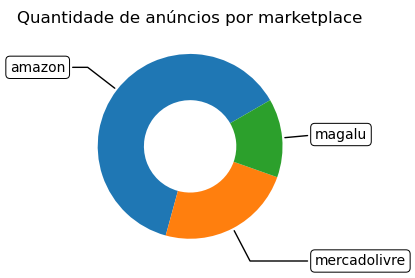

In [22]:
qt_anuncios = df_anuncios['marketplace'].value_counts()
labels, values = qt_anuncios.index, qt_anuncios.values

print(tabulate({'Marketplace': list(qt_anuncios.index), 'Quantidade': list(qt_anuncios.values)},headers="keys",intfmt=',',tablefmt='rounded_grid').replace(',','.'))
plot_donut(labels,values, 'Quantidade de anúncios por marketplace',startangle=30)

# Seleção da amostra

In [23]:
df_fiscais = pd.read_excel(FILE_FISCAIS)
df_fiscais

,Fiscal,Lotação,Login,Tarefas
0,Aécio Ramires de Mesquita,UO071,aeciom,1024
1,Carlos Juliano Pott,GR05,pott,1024
2,Cesar Alexandre Parazi,FIGF2,parazi,512
3,Darlan Lima Silva,UO073,darlan,1024
4,Eduardo Renato Rocha Brandao,GR02,eduardo,1024
5,Joao Luis Alves Tavares,UO021,joaotavares,1024
6,José Carlos da Silva,GR04,jcsilva,1024
7,Jose Luciano da Silva,GR06,jluciano,1024
8,José Marcelo Mesquita de Sousa,GR09,josemarcelo,1024
9,Josias Pereira de Barcelos,UO021,josias,1024


In [24]:
# lista e quantidade de fiscais
fiscais = df_fiscais.Login.to_list()
tarefas_fiscal = df_fiscais.Tarefas.to_list()

fiscais_amostra = []

for fiscal, n_tarefa in zip(fiscais,tarefas_fiscal):
    fiscais_amostra.extend([fiscal for i in range(n_tarefa)])
df_fiscais_amostra = pd.DataFrame(fiscais_amostra,columns=['Atribuído para'])

df_fiscais_amostra['Atribuído para'].value_counts()

Atribuído para
aeciom           1024
pott             1024
williams         1024
wesleychaves     1024
sinval           1024
sebastiao        1024
ronanj           1024
romildo          1024
pedro            1024
hans             1024
marcosrg         1024
marcelol         1024
leandrorb        1024
josias           1024
josemarcelo      1024
jluciano         1024
jcsilva          1024
joaotavares      1024
eduardo          1024
darlan           1024
thiagoalves       512
parazi            512
maxwelfreitas      12
Name: count, dtype: int64

In [25]:
df_fiscais_amostra

,Atribuído para
0,aeciom
1,aeciom
2,aeciom
3,aeciom
4,aeciom
...,...
21511,maxwelfreitas
21512,maxwelfreitas
21513,maxwelfreitas
21514,maxwelfreitas


In [26]:
# seleção da amostras
n_samples, _ = df_fiscais_amostra.shape
df_fiscaliza = df_anuncios.sample(n_samples,random_state=2304)
df_fiscaliza = df_fiscaliza.reset_index(drop=True)

# save file with all columns
df_fiscaliza.to_parquet(FILE_FULL_ISSUES)

# título da última tarefa no Fiscaliza
# as novas terão numeração sequencial a partir desta
fiscaliza_last_issue = 00000000
format_title = lambda i: f'LABEL_PACP_2024_{str(i+1+fiscaliza_last_issue).zfill(8)}'

columns_to_issues = ['nome', 'desc', 'img0', 'img1', 'img2']

df_fiscaliza['Projeto'] = 'Rotulagem de Dados'

df_fiscaliza['Título'] = df_fiscaliza.index.map(format_title)
df_fiscaliza['Descrição'] = df_fiscaliza[columns_to_issues].apply(lambda row: format_issue(row),axis=1)

df_fiscaliza['Tipo'] = 'Rotulagem de Dados'
df_fiscaliza['Situação'] = 'Responder pesquisa'

df_fiscaliza['Data de início'] = '29/04/2024'
df_fiscaliza['Data limite'] = '31/05/2024'

df_fiscaliza = df_fiscaliza.join(df_fiscais_amostra)
df_fiscaliza = df_fiscaliza.merge(df_fiscais[['Login','Lotação']],left_on='Atribuído para', right_on='Login')

df_fiscaliza.to_parquet(FILE_SAMPLES,index=False)

columns_to_issues = ['Projeto', 'Tipo', 'Situação', 'Título', 'Descrição', 'Data de início', 'Data limite', 'Atribuído para', 'Lotação']
df_fiscaliza[columns_to_issues].to_csv(FILE_ISSUES_TO_FISCALIZA,index=False,sep=';')


df_fiscaliza[columns_to_issues]

,Projeto,Tipo,Situação,Título,Descrição,Data de início,Data limite,Atribuído para,Lotação
0,Rotulagem de Dados,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00000001,h1. Streaming Box S Tucson 2018 A 2022 Carplay...,29/04/2024,31/05/2024,aeciom,UO071
1,Rotulagem de Dados,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00000002,h1. Smartphone Motorola Moto G52 XT2221-1 Dual...,29/04/2024,31/05/2024,aeciom,UO071
2,Rotulagem de Dados,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00000003,h1. Notebook Dell Latitude 7490 I5 8ª Ger Ddr4...,29/04/2024,31/05/2024,aeciom,UO071
3,Rotulagem de Dados,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00000004,"h1. Mini rede sem fio, placa de rede sem fio U...",29/04/2024,31/05/2024,aeciom,UO071
4,Rotulagem de Dados,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00000005,"h1. Fone Bluetooth TWS Kaidi KD-771 - 5.1, Tou...",29/04/2024,31/05/2024,aeciom,UO071
...,...,...,...,...,...,...,...,...,...
21511,Rotulagem de Dados,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00021512,h1. CAIXA ACUSTICA PCX6500,29/04/2024,31/05/2024,maxwelfreitas,UO021
21512,Rotulagem de Dados,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00021513,h1. Conector de cauda de celular 10 pcs carreg...,29/04/2024,31/05/2024,maxwelfreitas,UO021
21513,Rotulagem de Dados,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00021514,h1. Avantree Medley Clear - Fones de ouvido se...,29/04/2024,31/05/2024,maxwelfreitas,UO021
21514,Rotulagem de Dados,Rotulagem de Dados,Responder pesquisa,LABEL_PACP_2024_00021515,"h1. Hilitand Adaptador sem fio, placa de rede ...",29/04/2024,31/05/2024,maxwelfreitas,UO021


In [27]:
df_fiscaliza['Atribuído para'].value_counts()

Atribuído para
aeciom           1024
pott             1024
williams         1024
wesleychaves     1024
sinval           1024
sebastiao        1024
ronanj           1024
romildo          1024
pedro            1024
hans             1024
marcosrg         1024
marcelol         1024
leandrorb        1024
josias           1024
josemarcelo      1024
jluciano         1024
jcsilva          1024
joaotavares      1024
eduardo          1024
darlan           1024
thiagoalves       512
parazi            512
maxwelfreitas      12
Name: count, dtype: int64

╭───────────────┬──────────────╮
│ Marketplace   │   Quantidade │
├───────────────┼──────────────┤
│ amazon        │        13385 │
├───────────────┼──────────────┤
│ mercadolivre  │         5242 │
├───────────────┼──────────────┤
│ magalu        │         2889 │
╰───────────────┴──────────────╯


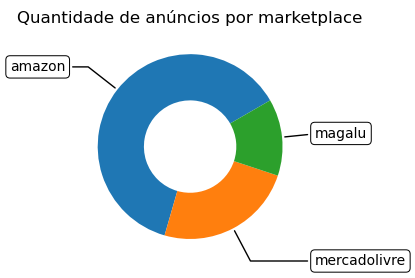

In [28]:
qt_anuncios = df_fiscaliza['marketplace'].value_counts()
labels, values = qt_anuncios.index, qt_anuncios.values

print(tabulate({'Marketplace': list(qt_anuncios.index), 'Quantidade': list(qt_anuncios.values)},headers="keys",intfmt=',',tablefmt='rounded_grid').replace(',','.'))
plot_donut(labels,values, 'Quantidade de anúncios por marketplace',startangle=30)

In [ ]:
# df_fiscaliza[columns_to_issues].to_csv(FILE_ISSUES_TO_FISCALIZA,index=False,sep=';')
for fiscal in df_fiscaliza['Atribuído para'].unique():
    file_issues_fiscal = f'../datasets/label_issues/20240423/issues_to_fiscaliza_{fiscal}.txt'
    df_fiscaliza[df_fiscaliza['Atribuído para']==fiscal][columns_to_issues].to_csv(file_issues_fiscal,index=False,sep=';', quoting=csv.QUOTE_ALL)
    